In [1]:
# Do not run again; this is to show what must be done to open the zip file downloaded from the Kaggle website.
# You cannot import multiple files, so you need to upload as a zip and then unzip.
import zipfile as zf
files = zf.ZipFile("dataset.zip", 'r') # Read only access of zip file
files.extractall('data-initial') # saved in this directory
files.close()

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

/var/folders/w5/_vl7tvj16f7c3190jn_03clc0000gn/T/ipykernel_21891/3399867613.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
from sklearn.metrics import roc_auc_score

# Define a dictionary to hold the OvA AUC metrics for each class
ova_auc_metrics = {}
for i, class_name in enumerate(['mild', 'moderate', 'normal', 'very-mild']):
    ova_auc_metrics[class_name] = tf.keras.metrics.AUC(name=f'ova_auc_{class_name}')

# Update the metrics list with the OvA AUC metrics
metrics = [tf.keras.metrics.AUC(name='auc'), *ova_auc_metrics.values()]

In [5]:
# Constants
FOLDERS     = ['train','val','test']
DIR_INPUT   = './data-initial/Dataset/'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented']

# Set seeds for reproducibility 
SEED        = 1888
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    normal,verymild,mild,moderate =0,0,0,0
    
    # print header
    msg = '{:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('normal','very mild','mild','moderate',
                                                        'normal %','very mild %','mild %','moderate %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in folders:
        for dirname, _, filenames in os.walk(os.path.join(path, folder)):
            for file in filenames:
                if "Non_Demented" in dirname:
                    normal+=1
                if "Very_Mild_Demented" in dirname:
                    verymild+=1
                if 'Mild_Demented' in dirname:
                    mild+=1
                if 'Moderate_Demented' in dirname:
                    moderate+=1
                    
    # calculate total and percentages            
    total = normal+verymild+mild+moderate
    if total >0:
        n  = round(normal/total,2)*100
        vm = round(verymild/total,2)*100
        m  = round(mild/total,2)*100
        mo =round(moderate/total,2)*100
    else:
        n,vm,m,mo = 0,0,0,0
        
    print("{:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(normal,verymild,mild,moderate,n,vm,m,mo))
    normal,verymild,mild,moderate =0,0,0,0

In [7]:
# Images by class in the input directory
images_by_class(DIR_INPUT,CLASS_LIST) 

normal   very mild   mild    moderate  normal %  very mild % mild %   moderate %
--------------------------------------------------------------------------------
    3200       2240    3136          64     37.0       26.0     36.0          1.0


In [8]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    Create the dir_path/folder if it doesn't already exist
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
        
    return folder_path

# create model directory
create_dir(DIR_WORK,'models',True)

'./models'

In [9]:
IMG_SIZE = [176,208]
BATCH_SIZE = 32

# Scale Images
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


# Image Generators
# train images: 4098
DIR_TRAIN   = os.path.join(DIR_WORK,'resampled','train')
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED 
)

# validation images: 1023
DIR_VAL   = os.path.join(DIR_WORK,'resampled','val')
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED
)

# test images:1279
DIR_TEST   = os.path.join(DIR_WORK,'resampled','test')
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED,
    shuffle     = False
)

# Training and Validation Steps
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

Found 4479 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 1282 images belonging to 4 classes.
steps per epoch:139


In [11]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    
    
    # Evaluate the results:
    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[results/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [12]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    
    if trainable_layers=='none':
        base.trainable = False
        print("No Trainabl Layers")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers are Trainable")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model are Trainable:")
        print("---------------------------------------------")
        
        # set all layers to not trainable
        base.trainable = False

        # loop through all layers from conv#_block# and set to true
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)

In [13]:
# function to build the model
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    Input: a base model, dropout rate, the number of filters in the dense node, 
           the learning rate and performance metrics
    Output: A compiled CNN model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [14]:
# training parameters
EPOCHS        = 15
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dense (Dense)               (None, 512)               20972032  
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                        

/var/folders/w5/_vl7tvj16f7c3190jn_03clc0000gn/T/ipykernel_21891/2578054416.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


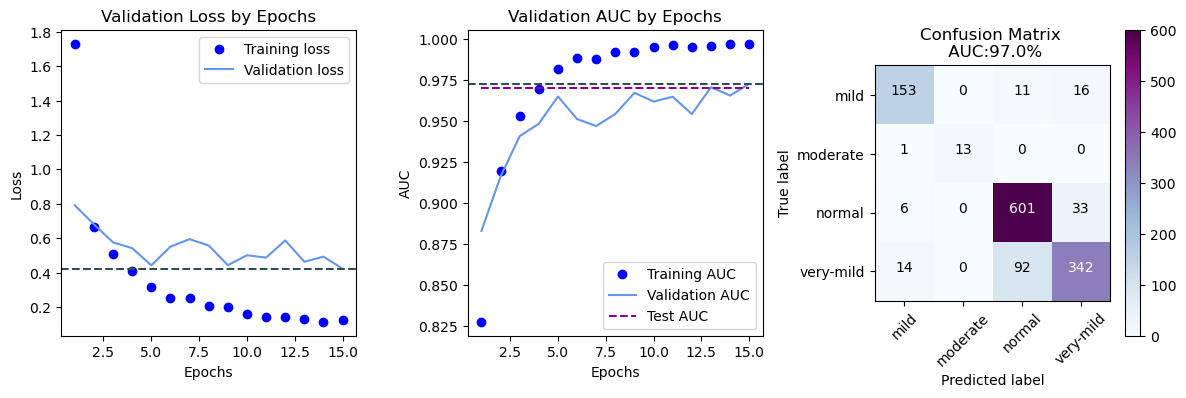

41/41 [==============================] - 16s 392ms/step
OvA AUC for mild: 0.9785591853196209
OvA AUC for moderate: 0.9996620099143759
OvA AUC for normal: 0.9564921631619938
OvA AUC for very-mild: 0.9315529719081879
INFO:tensorflow:Assets written to: ./models/base_model/assets


INFO:tensorflow:Assets written to: ./models/base_model/assets


Total Time:17.58


In [15]:
# Train Model: Base Model
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot training metrics
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

from sklearn.preprocessing import label_binarize

# Compute OvA AUC for each class
class_names = ['mild', 'moderate', 'normal', 'very-mild']

y_one_hot = label_binarize(y_actual, classes=np.arange(len(class_names)))
y_prob = model.predict(test_gen)
for i, class_name in enumerate(class_names):
  auc_value = roc_auc_score(y_one_hot[:, i], y_prob[:, i])
  print(f'OvA AUC for {class_name}: {auc_value}')


# Save the Model
model.save(os.path.join(DIR_MODELS,'base_model'))

# display runtime
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [16]:
# function to build the model
# add an additional conv layer with dropout and batch normalization
def build_transfer_model(conv_base,dropout,conv_nodes,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout +0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 5, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 5, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                     

/var/folders/w5/_vl7tvj16f7c3190jn_03clc0000gn/T/ipykernel_21891/2578054416.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


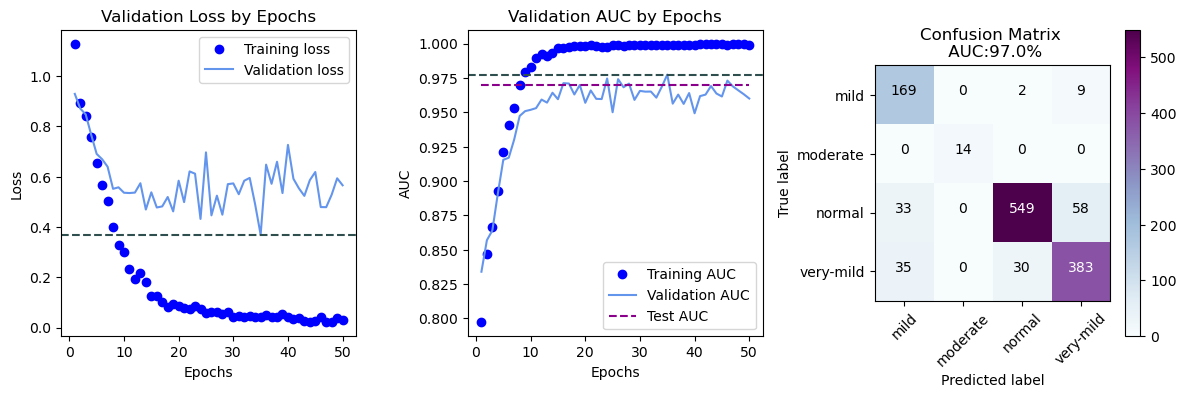

41/41 [==============================] - 21s 508ms/step
OvA AUC for mild: 0.9816948981649526
OvA AUC for moderate: 1.0
OvA AUC for normal: 0.9720234618380061
OvA AUC for very-mild: 0.9564598321342925
INFO:tensorflow:Assets written to: ./models/model_added_capacity/assets


INFO:tensorflow:Assets written to: ./models/model_added_capacity/assets


Total Time:142.35


In [17]:
# Base Model: Plus Additional Capacity
# training parameters
EPOCHS        = 50
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 10,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]



# Train Model: Base + Additional Capacity
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

from sklearn.preprocessing import label_binarize

# Compute OvA AUC for each class
class_names = ['mild', 'moderate', 'normal', 'very-mild']

y_one_hot = label_binarize(y_actual, classes=np.arange(len(class_names)))
y_prob = model.predict(test_gen)
for i, class_name in enumerate(class_names):
  auc_value = roc_auc_score(y_one_hot[:, i], y_prob[:, i])
  print(f'OvA AUC for {class_name}: {auc_value}')


# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Found 4479 images belonging to 4 classes.


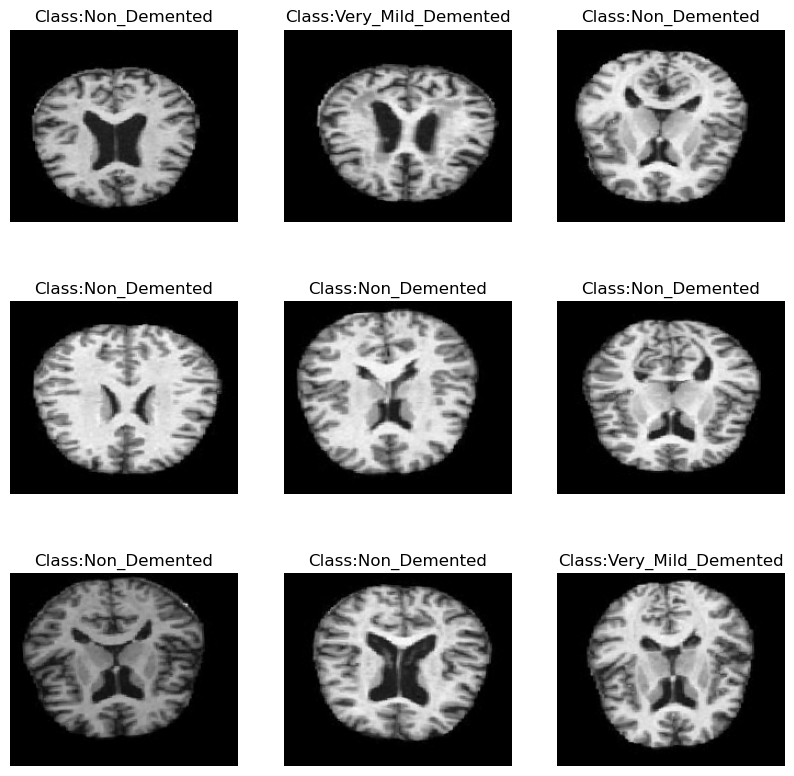

In [18]:
# Data Augmentation on training images
train_images = ImageDataGenerator(rescale            = 1./255,
                                  rotation_range     = 5,
                                  zoom_range         = 0.10,
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05)

# train image generator
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          
    seed        = SEED 
)

show_images(train_gen)

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 5, 2048)        8192      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 5, 1024)        18875392  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 5, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                     

/var/folders/w5/_vl7tvj16f7c3190jn_03clc0000gn/T/ipykernel_21891/2578054416.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


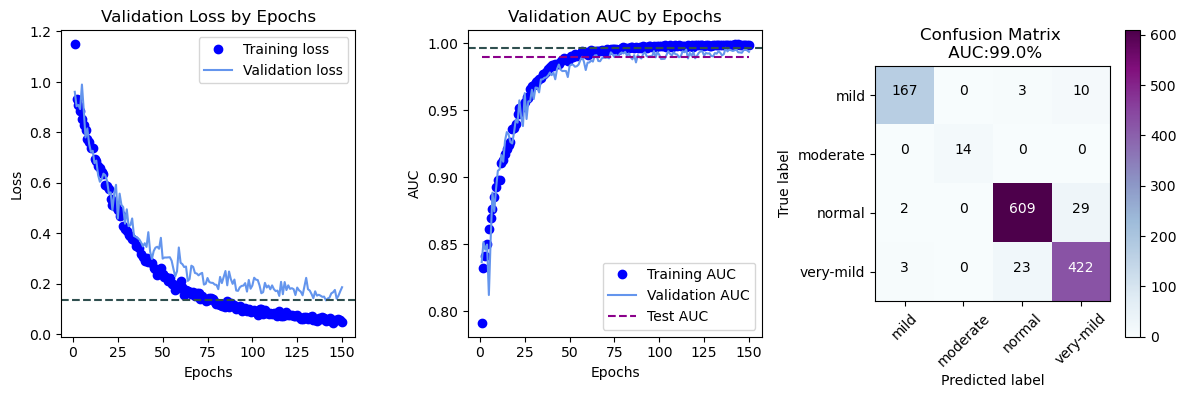

41/41 [==============================] - 19s 459ms/step
OvA AUC for mild: 0.9967382536801774
OvA AUC for moderate: 1.0
OvA AUC for normal: 0.9923116238317757
OvA AUC for very-mild: 0.9909108427543679
INFO:tensorflow:Assets written to: ./models/model_added_capacity/assets


INFO:tensorflow:Assets written to: ./models/model_added_capacity/assets


Total Time:410.13 mins


In [19]:
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc')]



# Train Model: Base + Optimized Hyperparameters + Data Augmentation
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        =callbacks 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

from sklearn.preprocessing import label_binarize

# Compute OvA AUC for each class
class_names = ['mild', 'moderate', 'normal', 'very-mild']

y_one_hot = label_binarize(y_actual, classes=np.arange(len(class_names)))
y_prob = model.predict(test_gen)
for i, class_name in enumerate(class_names):
  auc_value = roc_auc_score(y_one_hot[:, i], y_prob[:, i])
  print(f'OvA AUC for {class_name}: {auc_value}')


# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))